# Medical Insurance Cost Prediction Model

This project aims to predict the medical insurance costs for individuals based on various factors such as age, gender, BMI, number of children, alcohol habits, and region of residence. By leveraging a dataset of historical medical cost records, the model applies data preprocessing techniques and exploratory data analysis (EDA) to uncover patterns in the data.

The final predictive model uses machine learning algorithms to estimate insurance costs accurately. This solution can be utilized to assist insurance companies in risk assessment and policy pricing while providing valuable insights for healthcare analytics.

## **Import Libraries**

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Preprocessing and statistical tests
from scipy.stats import skew, kurtosis, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder, RobustScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

##Import Dataset

load the dataset and look at the first five rows of it.

In [ ]:
data = pd.read_csv('/content/medical_cost.csv')
data = data.rename(columns={'sex': 'gender'})
data.head()

,age,gender,bmi,children,alcohol,region,charges
0,19,female,27.900,0,yes,other,5065477.200
1,18,male,33.770,1,no,western,517665.690
2,28,male,33.000,3,no,western,1334838.600
3,33,male,22.705,0,no,central,6595341.183
4,32,male,28.880,0,no,central,1160056.560


###Data Shape Information



In [ ]:
print(f'Number of rows: {data.shape[0]}, columns: {data.shape[1]}')

Number of rows: 1338, columns: 7


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   alcohol   1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


From the above, we can see that the dataset consists of 2 columns containing floating-point values, 3 columns with categorical values, and the remaining columns comprising integer values.

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) involves using statistical summaries and visualizations to uncover trends, patterns, and verify assumptions. It focuses on examining relationships among independent features to understand how they influence one another.

##Statistical Summary

In [ ]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1.338000e+03
mean,39.207025,30.663397,1.094918,3.981127e+06
std,14.049960,6.098187,1.205493,3.633003e+06
min,18.000000,15.960000,0.000000,3.365622e+05
25%,27.000000,26.296250,0.000000,1.422086e+06
50%,39.000000,30.400000,1.000000,2.814610e+06
75%,51.000000,34.693750,2.000000,4.991974e+06
max,64.000000,53.130000,5.000000,1.913113e+07


##Check for Missing Value

In [ ]:
data.isnull().sum()

,0
age,0
gender,0
bmi,0
children,0
alcohol,0
region,0
charges,0


 we can conclude that there is no missing values in the dataset.


##Drop Duplicates

In [ ]:
duplicates = data.duplicated(keep=False)
num_duplicates = duplicates.sum()
duplicate_rows = data[duplicates]
print(f'Number of duplicates: {num_duplicates}')
print(duplicate_rows)

Number of duplicates: 2
     age gender    bmi  children alcohol   region    charges
195   19   male  30.59         0      no  central  491868.93
581   19   male  30.59         0      no  central  491868.93


From the above, we can see that there are duplicated rows. Let's drop the duplicates.

In [ ]:
data = data.drop_duplicates()
print(f'Number of rows: {data.shape[0]}, columns: {data.shape[1]}')

Number of rows: 1337, columns: 7


One row is dropped, we now have 1337 data points.

##Visualizations

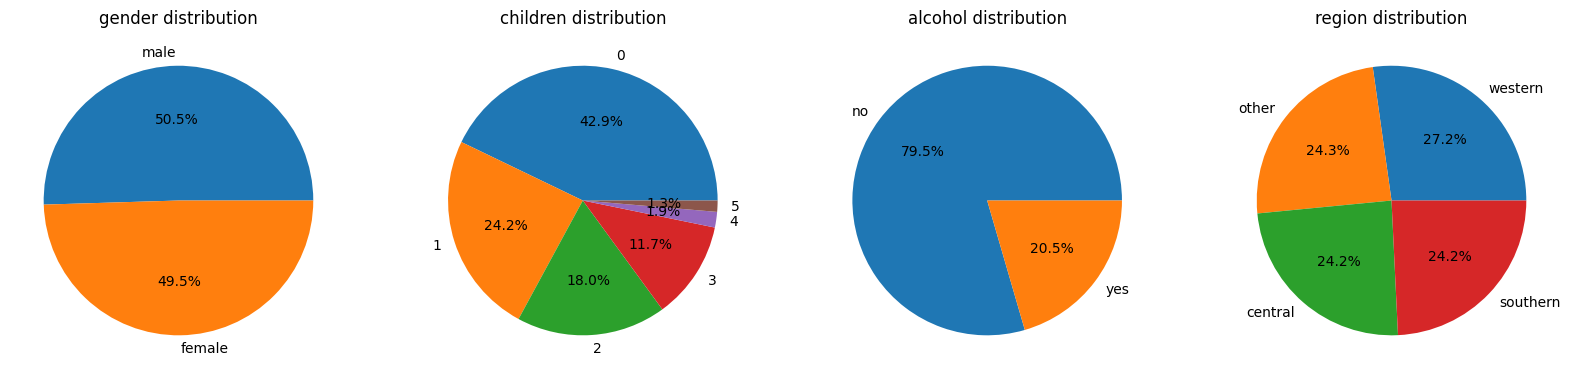

In [ ]:
features = ['gender', 'children', 'alcohol', 'region']

plt.subplots(1, 4, figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(1, 4, i + 1)
    x = data[col].value_counts()
    plt.pie(x.values, labels=x.index, autopct='%1.1f%%')
    plt.title(f'{col} distribution')
plt.show()

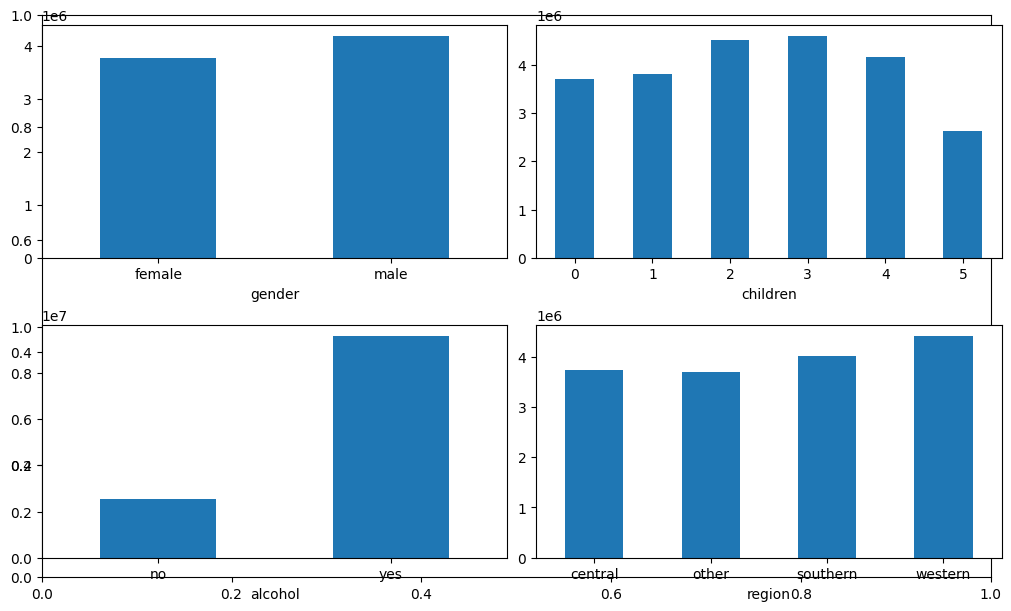

In [ ]:
features = ['gender', 'children', 'alcohol', 'region']

plt.subplots(figsize=(10, 6), layout='constrained')
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    data.groupby(col)['charges'].mean().plot.bar(rot=0)
plt.show()

The premium for alcohol is about three times what's charged for non-alcohol.

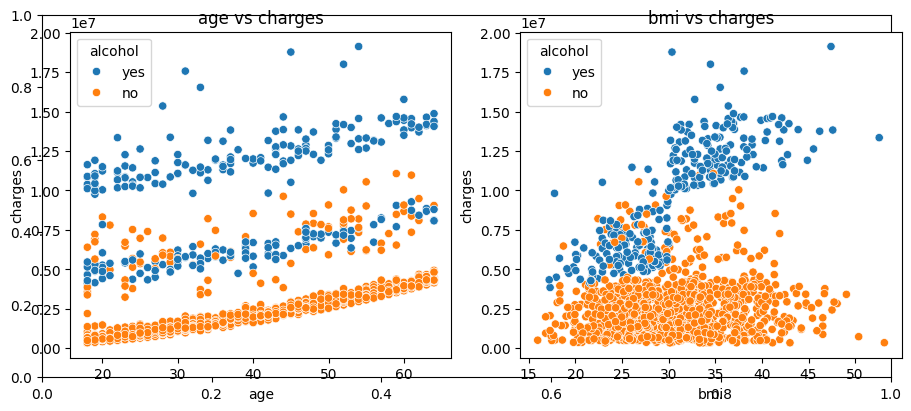

In [ ]:
features = ['age', 'bmi']

plt.subplots(figsize=(9, 4), layout='constrained')
for i, col in enumerate(features):
    plt.subplot(1, 2, i + 1)
    sns.scatterplot(data, x=col,y='charges', hue='alcohol')
    plt.title(f'{col} vs charges')
plt.show()

-Patients who use alcohol pay higher charges.

-The premium prices increase with age of patients.

-For patients who don't use alcohol, there is no major difference in charges, regardless of their weight.

-For patients who use alcohol, as the BMI increases, the charges also increase.


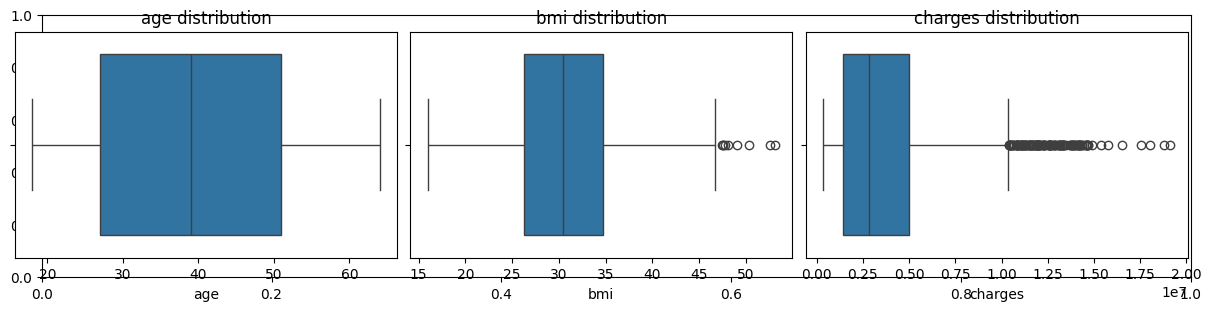

In [ ]:
features = ['age', 'bmi', 'charges']

plt.subplots(figsize=(12, 3), layout='constrained')
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data, x=col)
    plt.title(f'{col} distribution')
plt.show()

There are some outliers in the bmi columns.

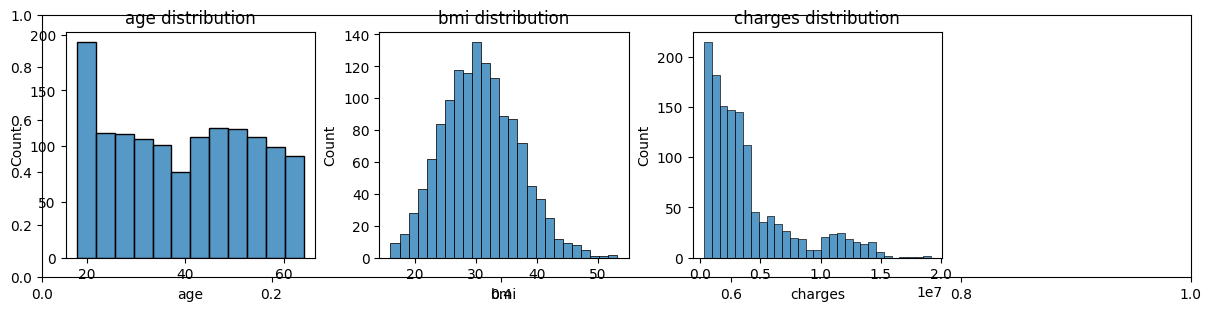

In [ ]:
features = ['age', 'bmi', 'charges']

plt.subplots(figsize=(12, 3), layout='constrained')
for i, col in enumerate(features):
    plt.subplot(1, 4, i + 1)
    sns.histplot(data, x=col)
    plt.title(f'{col} distribution')
plt.show()

##Check for Skewness & Kurtosis

Skewness

In [ ]:
features = ['age', 'bmi', 'charges']

for col in features:
    s = skew(data[col])
    if s >= -0.5 and s <= 0.5:
        print(f'Skewness of {col} = {s:.6f} [low or approximately symmetric]')
    elif s <= -1:
        print(f'Skewness of {col} = {s:.6f} [highly left skewed]')
    elif s >= 1:
        print(f'Skewness of {col} = {s:.6f} [highly right skewed]')
    else:
        print(f'Skewness of {col} = {s:.6f} [moderately skewed]')

Skewness of age = 0.054719 [low or approximately symmetric]
Skewness of bmi = 0.283596 [low or approximately symmetric]
Skewness of charges = 1.513690 [highly right skewed]


Data in both the age and BMI column approximately follow a normal distribution

Kurtosis

In [ ]:
features = ['age', 'bmi', 'charges']

for col in features:
    k = kurtosis(data[col], fisher=False)
    if k == 3:
        print(f'Kurtosis of {col} = {k:.6f} [perfect normal distribution or very close to it]')
    elif k < 3:
        print(f'Kurtosis of {col} = {k:.6f} [flat peak, light tails]')
    else:
        print(f'Kurtosis of {col} = {k:.6f} [sharp peak, heavy tails]')

Kurtosis of age = 1.755758 [flat peak, light tails]
Kurtosis of bmi = 2.942766 [flat peak, light tails]
Kurtosis of charges = 4.593743 [sharp peak, heavy tails]


From the above, we can see the dependent variable (charges) has a leptokurtic distribution. A leptokurtic distribution is more peaked and has longer tail than a normal distribution.

# Data Preprocessing

##Data Encoding

Before examining the relationship among the variables and modol development, let's encode the discrete categorical data (gender, alcohol, region)

In [ ]:
encoded = data.copy()

encoded['gender'] = encoded['gender'].map({'male': 1, 'female': 0})
encoded['alcohol'] = encoded['alcohol'].map({'yes': 1, 'no': 0})

# Ordinal encoding
enc = OrdinalEncoder()
encoded['region'] = enc.fit_transform(encoded[['region']])

encoded.head()

,age,gender,bmi,children,alcohol,region,charges
0,19,0,27.900,0,1,1.0,5065477.200
1,18,1,33.770,1,0,3.0,517665.690
2,28,1,33.000,3,0,3.0,1334838.600
3,33,1,22.705,0,0,0.0,6595341.183
4,32,1,28.880,0,0,0.0,1160056.560


##Examining Relationships among Features

Numerical Variables

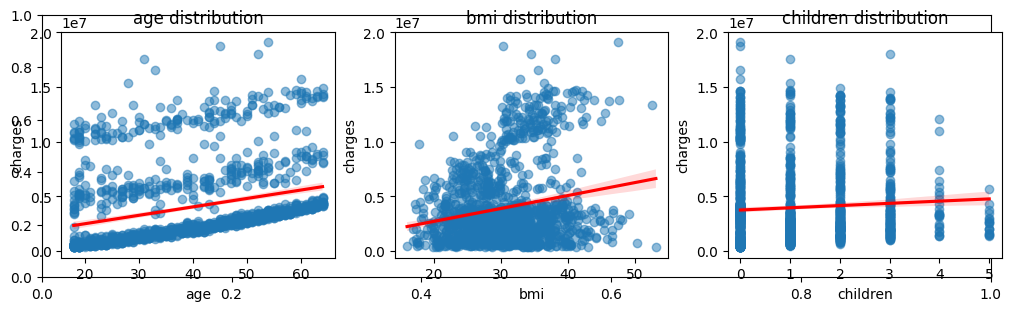

In [ ]:
features = ['age', 'bmi', 'children']

plt.subplots(figsize=(10, 3), layout='constrained')
for i, col in enumerate(features):
    plt.subplot(1, 3, i + 1)
    sns.regplot(data, x=col, y='charges', line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
    plt.title(f'{col} distribution')
plt.show()

Pearson Correlation

In [ ]:
encoded[['age', 'bmi', 'children', 'charges']].corr()['charges'].sort_values(ascending=False).round(6)

,charges
charges,1.000000
age,0.298308
bmi,0.198401
children,0.067389


Age seems to have a slightly stronger linear relationship with charges compared to bmi and children, but all the correlations are relatively weak, suggesting that there might be non-linear or more complex relationships at play that require further exploration.

....

Spearman's Rank Correlation

In [ ]:
encoded[['age', 'bmi', 'children', 'charges']].corr(method='spearman')['charges'].sort_values(ascending=False).round(6)

,charges
charges,1.000000
age,0.533523
children,0.132200
bmi,0.119585


Age appears to have a more notable positive rank correlation with charges in compared to children and bmi, for which the rank correlations are relatively weak.

.....


Kendall’s Tau Rank Correlation

In [ ]:
encoded[['age', 'bmi', 'children', 'charges']].corr(method='kendall')['charges'].sort_values(ascending=False).round(6)

,charges
charges,1.000000
age,0.474688
children,0.102232
bmi,0.082702


Age seems to have a more notable positive rank correlation with charges (i.e., as the age increases, the charges tend to increase in a somewhat consistent manner) in ompared to children and bmi, for which the rank correlations are relatively weak.

Categorical Variables

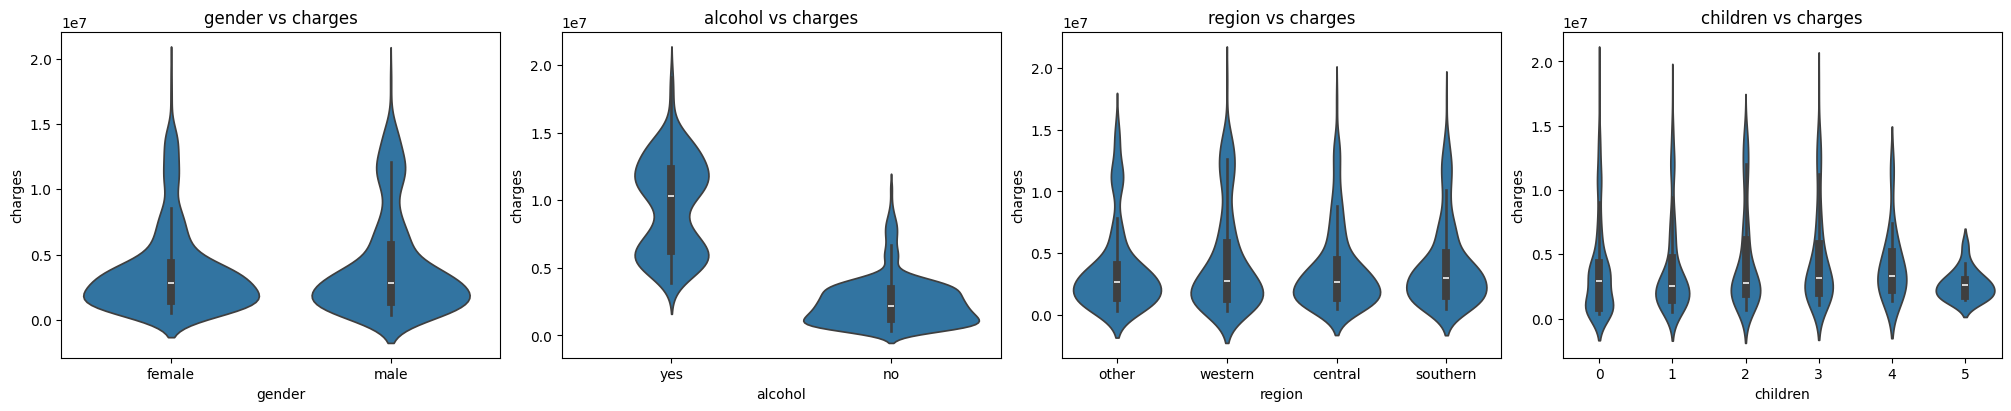

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4), layout='constrained')
for idx, x in enumerate(['gender', 'alcohol', 'region', 'children']):
    sns.violinplot(data, x=x, y='charges', ax=ax[idx])
    ax[idx].set_title(f'{x} vs charges')
plt.show()

Chi-Square Test of Independence

In [ ]:
def calculate_chi2_for_variable(data, independent_variable, dependent_variable):
    df = encoded.copy()
    df[f'{dependent_variable}_category'] = pd.cut(df[dependent_variable], bins=5)
    df = df.groupby(f'{dependent_variable}_category')[independent_variable].value_counts().unstack()
    list = []
    for category in data[independent_variable].unique():
        category = np.array(df[category])
        list.append(category)
    contingency_table = np.array(list)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f'For variable {independent_variable}: chi2 = {chi2:.6f}, p-value = {p:.6f}')

for x in ['gender', 'alcohol', 'region', 'children']:
    calculate_chi2_for_variable(encoded, x, 'charges')

For variable gender: chi2 = 9.345654, p-value = 0.053017
For variable alcohol: chi2 = 885.732642, p-value = 0.000000
For variable region: chi2 = 21.116012, p-value = 0.048707
For variable children: chi2 = 27.541453, p-value = 0.120706


-There might be a weak or borderline significant
association between charges and gender.

-There is a strong significant association between charges and whether a person is a alcohol.

-There is a significant association between charges and region.

-There is no significant association between charges and the number of children.

##Feature Selection

In [ ]:
X = encoded.drop(columns=['charges'])
y = encoded['charges']
feature_names = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso model
lasso = Lasso(alpha=0.1)  # Adjust the alpha value to control the regularization strength
lasso.fit(X_train, y_train)

# Perform feature selection using SelectFromModel
selector = SelectFromModel(lasso, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Print the names of selected features
selected_feature_names = [feature_names[i] for i, selected in enumerate(selector.get_support()) if selected]
print("Selected Feature Names:", selected_feature_names)

# Train a linear regression model on the selected features
model = LinearRegression()
model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

Selected Feature Names: ['age', 'gender', 'bmi', 'children', 'alcohol', 'region']
Root Mean Squared Error: 1796567.3234930015
R2 Score: 0.8048346102271572


# Model Development

##Baseline Model

In [ ]:
X = encoded.drop(columns=['charges'])
y = encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
}
results = []
for name, model in models.items():
    # Cross validation
    mean_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    mean_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    results.append([name, mean_rmse, mean_r2, test_rmse, test_r2])
df = pd.DataFrame(results, columns=['model', 'mean_rmse', 'mean_r2', 'test_rmse', 'test_r2'])
print(df)

               model     mean_rmse   mean_r2     test_rmse   test_r2
0  Linear Regression  1.839081e+06  0.725374  1.796567e+06  0.804835
1      Random Forest  1.481475e+06  0.822042  1.413856e+06  0.879128
2  Gradient Boosting  1.430672e+06  0.834367  1.290719e+06  0.899265
3      Decision Tree  1.990076e+06  0.677531  1.747528e+06  0.815344


##Hyperparameter Tuning

In [ ]:
X = encoded.drop(columns=['charges'])
y = encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'n_estimators': [200, 250, 300],
                   'max_depth': [3, 4, 5]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {'n_estimators': [50, 100, 150],
                   'learning_rate': [0.03, 0.04, 0.05],
                   'max_depth': [2, 3, 4]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {'max_depth': [3, 4, 5]}
    },
}

best_scores = {}
best_params = {}
test_scores = {}

for name, model_info in models.items():

    model = model_info['model']
    params = model_info['params']

    grid_search = GridSearchCV(model, params, cv=5)
    grid_search.fit(X_train, y_train)

    best_scores[name] = grid_search.best_score_.round(6)
    best_params[name] = grid_search.best_params_

    test_score = grid_search.score(X_test, y_test)
    test_scores[name] = round(test_score,6)

for name in models.keys():
    print(f'{name} - Best Score: {best_scores[name]}')
    print(f'Best Parameters: {best_params[name]}')
    print(f'Test Score: {test_scores[name]}\n')

Random Forest - Best Score: 0.843008
Best Parameters: {'max_depth': 4, 'n_estimators': 200}
Test Score: 0.900801

Gradient Boosting - Best Score: 0.843789
Best Parameters: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 100}
Test Score: 0.899935

Decision Tree - Best Score: 0.833364
Best Parameters: {'max_depth': 4}
Test Score: 0.897219



From the above, we can see that Random Forest is the best model.

##Final Model

In [ ]:
X = encoded.drop(columns=['charges'])
y = encoded['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_model = RandomForestRegressor(random_state=42, max_depth=4, n_estimators=200)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test Root Mean Squared Error:", rmse)
r2 = r2_score(y_test, y_pred)
print("Test R2 Score:", r2)

mean_rmse = np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print("CV Root Mean Squared Error:", mean_rmse)
mean_r2 = cross_val_score(final_model, X, y, cv=5, scoring='r2').mean()
print("CV R2 Score:", mean_r2)

Test Root Mean Squared Error: 1280843.9457978623
Test R2 Score: 0.9008007816170771
CV Root Mean Squared Error: 1362552.475405581
CV R2 Score: 0.8575016498298684


##Feature Importance

In [ ]:
important_features = pd.DataFrame(
    data=final_model.feature_importances_,
    index=X.columns,
    columns=['Importance']
).sort_values(by='Importance', ascending=False)
print(important_features)

          Importance
alcohol     0.692687
bmi         0.174980
age         0.120175
children    0.011648
region      0.000349
gender      0.000162


##Save Model

In [ ]:
from pickle import dump

dump(final_model, open('insurance_model_1.pkl', 'wb'))

##Predict on New Data

In [ ]:
print("Please enter the following details for the prediction:")

age = int(input("Age (between 18 and 100): "))
gender = input("Gender (male/female): ").lower()
bmi = float(input("BMI: "))
children = int(input("Number of children: "))
smoker = input("alcohol (yes/no): ").lower()
region = input("Region (western/souther/central/other): ").lower()

new_data = pd.DataFrame({
    'age': age, 'gender': gender, 'bmi': bmi, 'children': children, 'alcohol': smoker, 'region': region,
}, index=[0])

new_data['gender'] = new_data['gender'].map({'male': 1, 'female': 0})
new_data['alcohol'] = new_data['alcohol'].map({'yes': 1, 'no': 0})
new_data['region'] = enc.transform(new_data[['region']])

# print('Predicted Charge:', final_model.predict(new_data))

predicted_charge = final_model.predict(new_data)[0]
print(f"Predicted Cost: RS.{predicted_charge:,.2f}")



Please enter the following details for the prediction:
Age (between 18 and 100): 50
Gender (male/female): male
BMI: 23.90
Number of children: 0
alcohol (yes/no): yes
Region (western/souther/central/other): western
Predicted Cost: RS.7,232,646.11
